# LeNet and LeNet-5: Pioneering CNN Architectures

How can a neural network learn to recognize complex visual patterns—like handwritten digits—without relying on hand-crafted features?

In the late 1980s and early 1990s, hand-engineered feature extraction dominated machine learning approaches to computer vision. This process was laborious and often inflexible. **LeNet** {footcite}`lecun1989backpropagation` offered a radical alternative by showing that a network could learn these features directly from raw pixel data.

The most influential incarnation, **LeNet-5** {footcite}`lecun1998gradient`, demonstrated impressive performance on handwritten digit recognition, finding real-world application in automated check reading and postal code processing. Although modern networks have grown significantly in depth and complexity, the core ideas from LeNet remain fundamental to today’s convolutional neural networks (CNNs).

```{note}
LeNet popularized the key innovations of convolution, pooling, and end-to-end learning—approaches that form the foundation for modern deep learning in computer vision.
```

## Learning Objectives
- Understand the historical context and motivation behind the LeNet family of architectures.
- Explore the architectural components (convolution, pooling, and sparse connectivity) that enabled effective pattern learning.
- Implement a simplified version of LeNet-1 in PyTorch to gain hands-on experience.
- Reflect on how LeNet’s innovations paved the way for more advanced CNNs.

## Conceptual Foundation

Before LeNet, engineers painstakingly crafted feature extractors for each vision task: edges, corners, specific shapes, etc. This approach was time-consuming, difficult to generalize, and prone to missing subtle features crucial for classification.

LeNet challenged this paradigm by **automating feature extraction**. It did this through layers that systematically learn local patterns (via convolution) and gradually build more global representations (via subsampling/pooling). This hierarchical approach mimics aspects of human visual perception, where lower-level patterns combine into higher-level objects.

```{note}
**Historical Context**:
Yann LeCun’s work on applying backpropagation to convolutional architectures in the 1980s was met with skepticism. But the success of LeNet on real-world tasks (e.g., check reading at banks) helped spark wider interest in neural network approaches to image recognition.
```

## Architecture

LeNet actually refers to several iterative designs. In what follows, we examine two key versions: **LeNet-1** (the earliest demonstration) and **LeNet-5** (the widely known and more powerful network).

### LeNet-1

```{figure} https://miro.medium.com/v2/resize:fit:1400/format:webp/1*ge5OLutAT9_3fxt_sKTBGA.png
---
width: 100%
name: lenet
---
LeNet-1 architecture.
```

1. **Convolution (C1)**: Takes a $28\times28$ (originally $32\times32$ in some demos) grayscale image and applies 4 filters of size $5\times5$. This step captures basic patterns like edges and corners.

2. **Pooling (S2)**: Applies average pooling (subsampling) with a $2\times2$ window, reducing the spatial dimensions from $24\times24$ to $12\times12$. This coarse-grains the features, allowing the network to focus on more abstract patterns.

3. **Second Convolution (C3)**: Produces more feature maps (12 feature maps). By stacking multiple convolutions, the network builds increasingly complex features.

4. **Second Pooling (S4)**: Another average pooling layer further reduces spatial dimensions to $4\times4$.

5. **Fully Connected Layers**: The network flattens these features and passes them through a fully connected layer to produce a 10-class output (digits 0–9).

```{note}
This hierarchical processing—convolution followed by subsampling—mimics the structure of the visual cortex, where neurons respond to progressively more complex stimuli in each stage.
```

### LeNet-5

```{figure} https://www.datasciencecentral.com/wp-content/uploads/2021/10/1lvvWF48t7cyRWqct13eU0w.jpeg
---
width: 100%
name: lenet-5
---
LeNet-5 architecture.
```

LeNet-5 builds on LeNet-1 but **scales up the number of learnable parameters** and introduces a few architectural refinements:

1. **Input Normalization**: Inputs (grayscale images) are normalized to a range of roughly $[-0.1, 1.175]$. This centering speeds up training and stabilizes the gradients.

2. **Convolution + Subsampling Pairs**: Similar to LeNet-1, but with more feature maps and a **mean pooling** mechanism. Each pooling step is followed by a **non-linear activation** (often the sigmoid, though other activations can be used).

3. **Sparse Connectivity (C3)**: Not every feature map in the previous layer connects to every feature map in the next layer. This selective approach reduces parameters and encourages **diverse features** rather than overly correlated ones.

4. **Transition to 1D**: Instead of simply flattening, LeNet-5 includes a convolutional layer (C5) that bridges 2D feature maps to a fully connected layer, preserving more spatial structure.

5. **Final RBF Layer** (in the original paper): An additional radial-basis-function layer was sometimes used to enhance feature representation. Modern implementations often simplify this to a linear or fully connected layer.

```{note}
**Parameter Efficiency**: One reason LeNet-5 performed well on the limited hardware of the 1990s is its careful use of sparse connections to reduce the number of parameters.
```

## Implementation

In this section, we will implement a simplified **LeNet-1** in PyTorch. While LeNet-1 was traditionally trained with batch gradient descent and certain custom optimizations, our example will use **modern tooling**—such as **PyTorch Lightning** and the **Adam** optimizer—to streamline the training process.

### Dataset: MNIST

We will train our model on the MNIST dataset, a classic benchmark of $28\times28$ handwritten digits. MNIST is split into 60,000 training and 10,000 test images.

```{figure} https://production-media.paperswithcode.com/datasets/MNIST-0000000001-2e09631a_09liOmx.jpg
---
width: 100%
name: mnist
---
MNIST dataset (digits 0–9 in handwritten form).
```

```{tip}
**Why MNIST?**
- Small image size (28x28) → Perfect for simple convolutional nets.
- 10 distinct classes → Easy to measure classification accuracy.
- Widely used → Many existing examples to compare against.
```

### Data Preparation with PyTorch Lightning

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import pytorch_lightning as pl
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
from torchmetrics import Accuracy

class MNISTDataModule(pl.LightningDataModule):
    """
    PyTorch Lightning data module for MNIST dataset
    """
    def __init__(self, data_dir: str = './data', batch_size: int = 32):
        super().__init__()
        self.data_dir = data_dir
        self.batch_size = batch_size

        # Define transforms
        self.transform = transforms.Compose([
            transforms.ToTensor(),           # Convert PIL image to torch.Tensor
            transforms.Normalize((0,), (1,)) # Normalize to mean=0, std=1
        ])

    def prepare_data(self):
        """Download data if needed."""
        datasets.MNIST(self.data_dir, train=True, download=True)
        datasets.MNIST(self.data_dir, train=False, download=True)

    def setup(self, stage=None):
        """Setup train, val, and test datasets."""
        if stage == 'fit' or stage is None:
            mnist_full = datasets.MNIST(self.data_dir, train=True, transform=self.transform)
            self.mnist_train, self.mnist_val = random_split(
                mnist_full, [55000, 5000], generator=torch.Generator().manual_seed(42)
            )

        if stage == 'test' or stage is None:
            self.mnist_test = datasets.MNIST(self.data_dir, train=False, transform=self.transform)

    def train_dataloader(self):
        return DataLoader(self.mnist_train, batch_size=self.batch_size, shuffle=True, num_workers=1)

    def val_dataloader(self):
        return DataLoader(self.mnist_val, batch_size=self.batch_size, num_workers=1)

    def test_dataloader(self):
        return DataLoader(self.mnist_test, batch_size=self.batch_size, num_workers=1)

```{note}
**PyTorch Lightning DataModule**:
- Ensures consistent data splits for training, validation, and testing.
- Handles shuffling, batching, and transformation pipelines.
- Makes code cleaner and easier to maintain.
```

### Model Definition

In [2]:
class LeNet1(pl.LightningModule):
    """
    PyTorch Lightning implementation of LeNet-1
    """

    def __init__(self, learning_rate=1e-3):
        super(LeNet1, self).__init__()
        self.save_hyperparameters()

        # Metrics
        self.train_accuracy = Accuracy(task="multiclass", num_classes=10)
        self.val_accuracy = Accuracy(task="multiclass", num_classes=10)
        self.test_accuracy = Accuracy(task="multiclass", num_classes=10)

        # First convolutional layer (Input: 1x28x28 -> Output: 4x24x24)
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=4, kernel_size=5, stride=1)

        # Average pooling layer (4x24x24 -> 4x12x12)
        self.pool = nn.AvgPool2d(kernel_size=2, stride=2)

        # Second convolutional layer (4x12x12 -> 12x8x8)
        self.conv2 = nn.Conv2d(in_channels=4, out_channels=12, kernel_size=5, stride=1)

        # Fully connected layer (12*4*4=192 -> 10)
        self.fc = nn.Linear(12 * 4 * 4, 10)

        # Initialize weights
        self._init_weights()

        # Track losses over time (for visualization)
        self.val_losses = []
        self.train_losses = []

    def _init_weights(self):
        """Initialize weights with Xavier initialization."""
        for m in self.modules():
            if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                nn.init.zeros_(m.bias)

    def forward(self, x):
        # First conv block
        x = self.conv1(x)
        x = torch.tanh(x)  # Using tanh for nonlinearity
        x = self.pool(x)

        # Second conv block
        x = self.conv2(x)
        x = torch.tanh(x)
        x = self.pool(x)

        # Flatten and fully connected
        x = x.view(-1, 12 * 4 * 4)
        x = self.fc(x)
        return x

    def configure_optimizers(self):
        """Define optimizer and LR scheduler."""
        optimizer = torch.optim.Adam(self.parameters(), lr=self.hparams.learning_rate)
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
            optimizer, mode="min", factor=0.1, patience=10, verbose=True
        )
        return {
            "optimizer": optimizer,
            "lr_scheduler": {"scheduler": scheduler, "monitor": "val_loss"}
        }

    def training_step(self, batch, batch_idx):
        """Train on a single batch."""
        x, y = batch
        logits = self(x)
        loss = F.cross_entropy(logits, y)

        acc = self.train_accuracy(logits, y)
        self.log("train_loss", loss, prog_bar=True)
        self.log("train_acc", acc, prog_bar=True)

        self.train_losses.append({"loss": loss.item(), "acc": acc.item()})
        return loss

    def validation_step(self, batch, batch_idx):
        """Validate on a single batch."""
        x, y = batch
        logits = self(x)
        loss = F.cross_entropy(logits, y)

        acc = self.val_accuracy(logits, y)
        self.log("val_loss", loss, prog_bar=True)
        self.log("val_acc", acc, prog_bar=True)

        self.val_losses.append({"loss": loss.item(), "acc": acc.item()})

    def test_step(self, batch, batch_idx):
        """Test on a single batch."""
        x, y = batch
        logits = self(x)
        loss = F.cross_entropy(logits, y)

        acc = self.test_accuracy(logits, y)
        self.log("test_loss", loss, prog_bar=True)
        self.log("test_acc", acc, prog_bar=True)

### Training the Model

In [3]:
# Initialize model and data
model = LeNet1(learning_rate=1e-3)
data_module = MNISTDataModule(batch_size=256)

# Initialize trainer
trainer = pl.Trainer(
    max_epochs=2,
    accelerator="auto",  # Use GPU if available
    devices=1,
)

# Train
trainer.fit(model, data_module)

GPU available: True (mps), used: True


TPU available: False, using: 0 TPU cores


HPU available: False, using: 0 HPUs


/Users/skojaku-admin/miniforge3/envs/advnetsci/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "

  | Name           | Type               | Params | Mode 
--------------------------------------------------------------
0 | train_accuracy | MulticlassAccuracy | 0      | train
1 | val_accuracy   | MulticlassAccuracy | 0      | train
2 | test_accuracy  | MulticlassAccuracy | 0      | train
3 | conv1          | Conv2d             | 104    | train
4 | pool           | AvgPool2d          | 0      | train
5 | conv2          | Conv2d             | 1.2 K  | train
6 | fc             | Linear             | 1.9 K  | train
--------------------------------------------------------------
3.2 K     Trainable params
0         Non-trainable params
3.2 K     Total params
0.013     Total estimated model params size

Sanity Checking: |                                                                                            …

/Users/skojaku-admin/miniforge3/envs/advnetsci/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:420: Consider setting `persistent_workers=True` in 'val_dataloader' to speed up the dataloader worker initialization.


/Users/skojaku-admin/miniforge3/envs/advnetsci/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:420: Consider setting `persistent_workers=True` in 'train_dataloader' to speed up the dataloader worker initialization.


Training: |                                                                                                   …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

`Trainer.fit` stopped: `max_epochs=2` reached.


```{tip}
**Check GPU usage**:
- If you have a GPU available, `accelerator="auto"` automatically leverages it.
- Otherwise, it trains on CPU, which is slower but will still work for a small model like LeNet-1.
```

### Monitoring Validation Loss

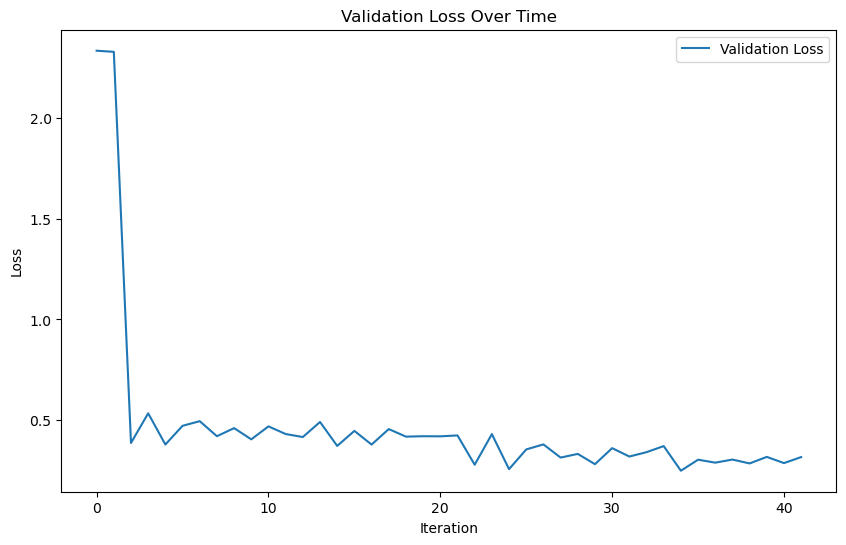

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

df_val = pd.DataFrame(model.val_losses)
df_val["Iteration"] = df_val.index

fig, ax = plt.subplots(figsize=(10, 6))
sns.lineplot(x="Iteration", y="loss", data=df_val, label="Validation Loss", ax=ax)
ax.set_title("Validation Loss Over Time")
ax.set_xlabel("Iteration")
ax.set_ylabel("Loss")
plt.show()

### Testing

In [5]:
trainer.test(model, data_module)

/Users/skojaku-admin/miniforge3/envs/advnetsci/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:420: Consider setting `persistent_workers=True` in 'test_dataloader' to speed up the dataloader worker initialization.


Testing: |                                                                                                    …

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.9190000295639038     │
│         test_loss         │     0.287288099527359     │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 0.287288099527359, 'test_acc': 0.9190000295639038}]

Observe the final test loss and test accuracy. Even this simple LeNet-1 inspired model often achieves high accuracy on MNIST—demonstrating how effective early CNN architectures can be.

## Reflection and Exercises

1. **Experiment**:
   - Vary the learning rate and batch size to see how training dynamics change.
   - Replace `tanh` activation with `ReLU` or `Sigmoid` and compare performance.

2. **Visual Inspection**:
   - Hand-draw a digit (e.g., using a graphics tool) and see whether the model correctly classifies it. If it fails, hypothesize why (differences in stroke thickness, image alignment, etc.).

3. **Architectural Tweaks**:
   - Try adding an additional convolutional layer or using different pooling strategies (like max pooling) to see if you can improve accuracy.


```{note}
**Real-world Application**:
LeNet’s core ideas are still used in modern banking systems to read checks automatically. Its principle of learning features from raw data underpins almost all modern deep-learning-based image classification systems.
```

## Further Reading

- [**Writing LeNet5 from Scratch in PyTorch (DigitalOcean)**](https://www.digitalocean.com/community/tutorials/writing-lenet5-from-scratch-in-python)
- [**PyTorch LeNet Implementation Video**](https://m.youtube.com/watch?v=fcOW-Zyb5Bo&pp=ygUGI2xlbmV0)
- [**Original LeCun Paper**](http://yann.lecun.com/exdb/publis/pdf/lecun-01a.pdf)

```{footbibliography}
:style: unsrt
:filter: docname in docnames
```

## Summary

In summary, **LeNet** {footcite}`lecun1989backpropagation` and **LeNet-5** {footcite}`lecun1998gradient` formed the basis for convolutional networks that learn directly from data. By incorporating convolution, subsampling, sparse connectivity, and end-to-end training, LeNet demonstrated how networks can autonomously discover robust representations—laying the groundwork for today’s deep learning revolution.